In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy.stats import chi2_contingency
from fuzzywuzzy import process
from rapidfuzz import process, fuzz
import re




/Users/caiocastro/Padrao/GitHub/PJ_Interno/myenv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('bases/PAC_NTECcleaned.csv')

In [3]:
labels = ['1-50', '51-200', '201-500', '501-1000', '1001-5000', '5001-10000', '10001+']


def exploratory_report(df, target_column, target_value, explained_column):

    list_of_x = []
    list_of_y_abs = []
    list_of_y_proportion = []
   
    new_df = df[[target_column, explained_column]].copy()
        
    # Store the new DataFrame in a dictionary with a dynamic name
    df_total = f'{df}{explained_column}'
    data_frames_dict = {df_total: new_df}

    # Calculate the mean proportion of the target value
    total_count = data_frames_dict[df_total].shape[0]

    target_count = data_frames_dict[df_total][data_frames_dict[df_total][target_column] == target_value].shape[0]

    mean_proportion = target_count / total_count * 100


    print(data_frames_dict[df_total].shape)
    data_frames_dict[df_total].head()

    for value in data_frames_dict[df_total][explained_column].unique():
        
        new_df = data_frames_dict[df_total][data_frames_dict[df_total][explained_column] == value]
        data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'] = new_df


    print('Total:', data_frames_dict[df_total].shape[0])

    for value in data_frames_dict[df_total][explained_column].unique():

        print(f"{value}: {data_frames_dict[df_total][data_frames_dict[df_total][explained_column] == value].shape[0]}")

    for value in data_frames_dict[df_total][explained_column].unique():

        new_df = data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'][data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'][target_column] == target_value]
        data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'] = new_df

    for value in data_frames_dict[df_total][explained_column].unique():
        
        print(f"{value}  {target_value}: {data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0]}")
        print(f"{value}  Total%: {data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'].shape[0]}")
        print(f'Percentualmente: {100 * data_frames_dict[f"{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}"].shape[0] / data_frames_dict[f"{data_frames_dict[df_total]}_vs_{value}"].shape[0]:.2f}%', end='\n\n')

        list_of_x.append(f'{value} vs {target_value}')
        list_of_y_abs.append(data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0])
        list_of_y_proportion.append(round(100 * data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}_vs_{target_value}'].shape[0] / data_frames_dict[f'{data_frames_dict[df_total]}_vs_{value}'].shape[0], 2))



    if explained_column != "Mês" and explained_column != "Dia da Semana" and explained_column != "Setor" and explained_column !="Raio" and explained_column != "HorasCorte" and explained_column != "employee_category":
        # Zip the lists and sort based on list_of_y_abs
        sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: x[0], reverse=False)

        # Unzip the sorted data
        sorted_x, sorted_y_abs, sorted_y_proportion = zip(*sorted_data)

        sorted_x = tuple(x.split(' vs ')[0] for x in sorted_x)

        mean_abs = np.mean(sorted_y_abs)
        
        # mean_proportion = np.mean(sorted_y_proportion)

        custom_palette = select_colors(len(sorted_x))

        plt.figure(figsize=(10, 5))

        # Create bar plot for absolute values with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_abs, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_abs, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Aparições')
        # plt.title(f'Problemas de {target_value.lower()} por {explained_column.lower()}')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.0f}'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

        plt.figure(figsize=(10, 5))

        # Create bar plot for proportions with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_proportion, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_proportion, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Proporção')
        # plt.title(f'Problemas {target_value.lower()} por {explained_column.lower()} (Percentualmente)')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol
        plt.show()
        
    else:

        if explained_column == "Mês":
            # Sorting by months by zipping
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Mês.index(x[0].split(' vs ')[0]), reverse=False)
        if explained_column == "Dia da Semana":
            # Sorting by days of the week by zipping
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: DiadaSemana.index(x[0].split(' vs ')[0]), reverse=False)
            
        if explained_column == "Raio":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Raio.index(x[0].split(' vs ')[0]), reverse=False)

        if explained_column == "HorasCorte":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: Horarios.index(x[0].split(' vs ')[0]), reverse=False)

        if explained_column == "employee_category":
            sorted_data = sorted(zip(list_of_x, list_of_y_abs, list_of_y_proportion), key=lambda x: labels.index(x[0].split(' vs ')[0]), reverse=False)
        # Unzip the sorted data
        sorted_x, sorted_y_abs, sorted_y_proportion = zip(*sorted_data)
        
        sorted_x = tuple(x.split(' vs ')[0] for x in sorted_x)
        # Create bar plot for absolute values with sorted data

        mean_abs = np.mean(sorted_y_abs)

        # mean_proportion = np.mean(sorted_y_proportion)


        custom_palette = select_colors(len(sorted_x))

        plt.figure(figsize=(10, 5))

        # Create bar plot for absolute values with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_abs, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_abs, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Aparições')
        # plt.title(f'Problemas de {target_value.lower()} por {explained_column.lower()}')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.0f}'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()

        plt.figure(figsize=(10, 5))

        # Create bar plot for proportions with sorted data
        sns.barplot(x=sorted_x, y=sorted_y_proportion, hue=sorted_x, palette=custom_palette)
        plt.axhline(mean_proportion, color='red', linestyle='--')
        # plt.xlabel(f'{explained_column}')
        # plt.ylabel('Proporção')
        # plt.title(f'Problemas {target_value.lower()} por {explained_column.lower()} (Percentualmente)')
        plt.xticks(rotation=90)
        # plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol
        plt.show()


In [4]:
bluey = [
    '#001834',
    '#002147',
    '#002a5b',
    '#00336f',
    '#003c82',
    '#004596',
    '#004ea9',
    '#0057bd',
    '#0060d1',
    '#0069e4',
    '#0072f8','#0D7CFF', '#2087FF', '#3492FF', '#479CFF', '#5BA7FF', '#6FB1FF', '#82BCFF', '#96C6FF', '#A9D1FF', '#BDDCFF', '#D1E6FF', '#E4F1FF', '#F8FBFF']


orangey = [
    "#77410E",
    "#8E4E11",
    "#A55A13",
    "#BD6715",
    "#D47317",
    "#E7801E",
    "#EA8D34",
    "#ED9A4B",
    "#F0A762",
    "#F2B479"
]

orangey_reversed = [
    "#F2B479",   
    "#E7801E",
]


bluey_short = [
    '#A9D1FF',
    '#D1E6FF'
]
# Neutral point
neutral = ['#FFFFFF']

# Combined diverging palette
diverging_palette = bluey_short + orangey_reversed    

def select_colors(num_columns):
    if num_columns >= len(bluey):
        return bluey
    
    step = len(bluey) // num_columns
    selected_colors = bluey[:num_columns * step:step]
    return selected_colors

In [5]:
# Write a regex expression to capture the date bewteen the parenthesis in "Semana"


In [6]:
# Convert the "Semana" column to datetime

df['Semana'] = pd.to_datetime(df['Semana'])

In [7]:
df

,Semana,Empresa,Setor do LinkedIn,Número de Funcionários,Nome,Cargo,Email,Prospecção,STATUS,Cadência,Hunter,Portfólio
0,2024-08-01,MatchVerse,Education,11-50,Gabriel Vinicius,Founder/Co-founder,email@example.com,E-mail,Não Respondeu,NaN,gustavo.baeta,Dev - App
1,2024-01-22,Movidaria,Education,11-50,Leticia Casavella,Sócio,email@example.com,E-mail,Não Respondeu,NaN,gustavo.baeta,Dev - App
2,2024-01-22,Movidaria,Education,11-50,Leticia Casavella,Sócio,email@example.com,E-mail,Não Respondeu,NaN,gustavo.baeta,Dev - App
3,2024-01-22,Movidaria,Education,11-50,Alcir Miguel Jr.,Sócio,email@example.com,E-mail,Não Respondeu,NaN,gustavo.baeta,Dev - App
4,2024-01-22,Movidaria,Education,11-50,Alcir Miguel Jr.,Sócio,email@example.com,E-mail,Não Respondeu,NaN,gustavo.baeta,Dev - App
...,...,...,...,...,...,...,...,...,...,...,...,...
3872,2024-07-29,EVO,financial services,11-50,Andre Pacheco,Gerente de Operações,andre.pacheco@evo.com.br,E-mail,Não Respondeu,NaN,luizhenrique.silva,Product Discovery
3873,2024-07-29,Ore Investments,financial services,11-50,Eduardo Cardoso,Sócio,eduardo.cardoso@oreinvestments.com.br,E-mail,Não Respondeu,NaN,luizhenrique.silva,Product Discovery
3874,2024-07-29,Ore Investments,financial services,11-50,Ricardo Lopes,Sócio,ricardo.lopes@oreinvestments.com.br,E-mail,Não Respondeu,NaN,luizhenrique.silva,Product Discovery
3875,2024-07-29,Ore Investments,financial services,11-50,Thiago Bonas,Sócio,thiago.bonas@oreinvestments.com.br,E-mail,Não Respondeu,NaN,luizhenrique.silva,Product Discovery


<Axes: xlabel='Semana'>

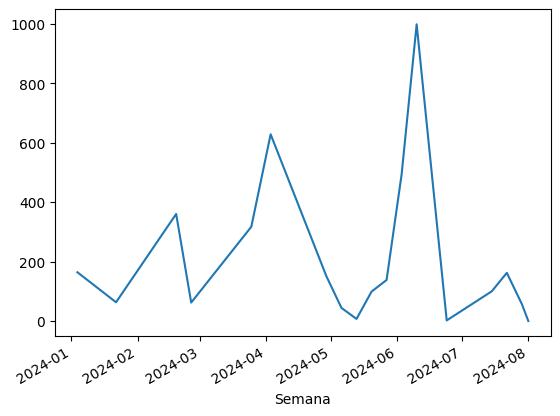

In [8]:
# Plot a time series for the ammount of rows per week

df['Semana'].value_counts().sort_index().plot()

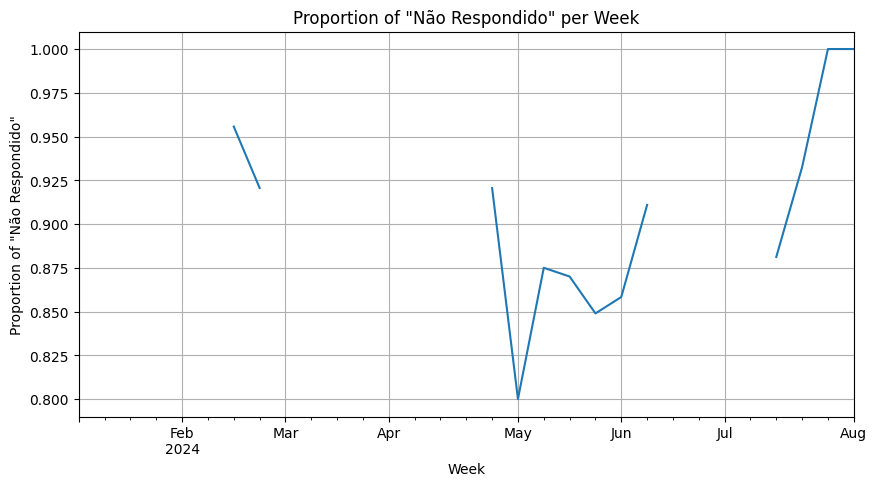

In [9]:
df['Não Respondido'] = df['STATUS'] == 'Não Respondeu'

# Group by week and calculate the proportion of "Não Respondido"
weekly_proportion = df.resample('W-Mon', on='Semana')['Não Respondido'].mean()

# Plotting
plt.figure(figsize=(10, 5))
weekly_proportion.plot( linestyle='-')
plt.title('Proportion of "Não Respondido" per Week')
plt.xlabel('Week')
plt.ylabel('Proportion of "Não Respondido"')
plt.grid(True)
plt.show()

In [10]:
# Count the frequency of the STATUS column

df['STATUS'].value_counts()


STATUS
Não Respondeu          3514
Não se Interessou       113
Contato Respondido       99
Reunião Marcada          89
Contato Encaminhado      17
Lead                     14
Não Se Interessou         1
Name: count, dtype: int64

In [11]:
#dropna of the first 6 columns

df = df.dropna(subset=df.columns[:6])

In [12]:
# Clean the values of Setor do Linkedin column

df['Setor do LinkedIn'] = df['Setor do LinkedIn'].str.lower().str.strip()

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/1406790230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Setor do LinkedIn'] = df['Setor do LinkedIn'].str.lower().str.strip()


In [13]:
def process_numero_de_funcionarios(value):
    try:
        # Replace different dashes with a standard dash
        value = re.sub(r'–|—', '-', value)
        # Handle ranges
        if '-' in value:
            min_val, max_val = map(int, re.split(r'\s*-\s*', value))
            return (min_val + max_val) / 2
        else:
            return int(value)
    except ValueError:
        # Handle invalid entries
        return None

# Apply the function to the 'Número de Funcionários' column
df['Número de Funcionários'] = df['Número de Funcionários'].apply(process_numero_de_funcionarios)

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/2024980564.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Número de Funcionários'] = df['Número de Funcionários'].apply(process_numero_de_funcionarios)


In [14]:
# Create a df with only the most frequent "Setor do LinkedIn" values

thresholds = [0, 50, 200, 500, 1000, 5000, 10000, float('inf')]
labels = ['1-50', '51-200', '201-500', '501-1000', '1001-5000', '5001-10000', '10001+']

status_encoding = {'Não Respondeu' : 0 , "Não se Interessou" :  0,  "Contato Respondido" : 1, "Contato Encaminhado" : 1,  "Reunião Marcada" : 2, "Lead": 3, "Projeto" : 3}

df['STATUS_encoded'] = df['STATUS'].map(status_encoding)

df.dropna(subset=['STATUS_encoded'], inplace=True)

df.dropna(subset=['Número de Funcionários', 'Empresa'], inplace=True)

idx = df.groupby('Empresa')['STATUS_encoded'].idxmax()


df_companies = df.loc[idx]

df_companies


/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/2450860264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATUS_encoded'] = df['STATUS'].map(status_encoding)
/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/2450860264.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['STATUS_encoded'], inplace=True)
/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/2450860264.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

,Semana,Empresa,Setor do LinkedIn,Número de Funcionários,Nome,Cargo,Email,Prospecção,STATUS,Cadência,Hunter,Portfólio,Não Respondido,STATUS_encoded
1131,2024-03-25,New Vegas,marketing & advertising,30.5,Ian,CEO,ian@newvegas.com.br,E-mail,Não Respondeu,NaN,guilherme.boen,Dev - Site,True,0.0
1681,2024-04-29,(ꓭ/ CodeBit - Programando Soluções,computer software & internet,125.5,Heitor Cunha,Founder/Co-founder,heitor@codebit.com.br,E-mail,Não Respondeu,NaN,alan.zisman,Dev - Site,True,0.0
1331,2024-03-25,.COMPOS,information technology & services,30.5,Katuchi Iseki,Diretor de Tecnologia,katuchi@compos.net.br,E-mail,Não Respondeu,NaN,alan.zisman,Dev - Site,True,0.0
1258,2024-03-25,100 Open Startups,education,30.5,Bruno,CEO,-,LinkedIn,Não Respondeu,NaN,guilherme.boen,Dev - Site,True,0.0
3494,2024-06-10,123 Comprou!,retail,30.5,Fernando Garcia,CEO,fernando@123comprou.com.br,E-mail,Não Respondeu,luizhenrique.silva,luizhenrique.silva,Dev - Site,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2024-02-19,zoop.pet,veterinary,30.5,Jean Carlos Zanco,CEO,jean.zanco@kvarch.com,LinkedIn,Não Respondeu,NaN,bruno.santos,Dev - Site,True,0.0
1410,2024-03-25,Água na Caixa®,food & beverages,30.5,Rodrigo Azevedo,Gerente de Logística/Supply Chain,rodrigo@aguanacaixa.com.br,E-mail,Não Respondeu,NaN,eduardo.kishi,Dev - Site,True,0.0
3293,2024-06-10,Évora S.A.,financial services,30.5,Edison Alves,Gerente de Operações,edison.pacheco@evora.com,E-mail,Não Respondeu,luizhenrique.silva,luizhenrique.silva,Dev - Site,True,0.0
666,2024-04-03,Ícone Energia,energy & environment,30.5,Adriano Ricardo Souza Macedo,CEO,adriano.souza@iconeenergia.com.br,LinkedIn,Não Respondeu,NaN,matheus.santos,Dev - Site,True,0.0


(1777, 2)
Total: 1777
marketing & advertising: 95
computer software & internet: 168
information technology & services: 317
education: 99
health & fitness: 572
real estate: 59
financial services: 233
human resources: 73
outros: 32
veterinary: 53
logistics & supply chain: 9
energy & environment: 20
construction: 18
food & beverages: 19
telecommunications: 10
marketing & advertising  Reunião Marcada: 1
marketing & advertising  Total%: 95
Percentualmente: 1.05%

computer software & internet  Reunião Marcada: 17
computer software & internet  Total%: 168
Percentualmente: 10.12%

information technology & services  Reunião Marcada: 22
information technology & services  Total%: 317
Percentualmente: 6.94%

education  Reunião Marcada: 5
education  Total%: 99
Percentualmente: 5.05%

health & fitness  Reunião Marcada: 13
health & fitness  Total%: 572
Percentualmente: 2.27%

real estate  Reunião Marcada: 0
real estate  Total%: 59
Percentualmente: 0.00%

financial services  Reunião Marcada: 21
financ

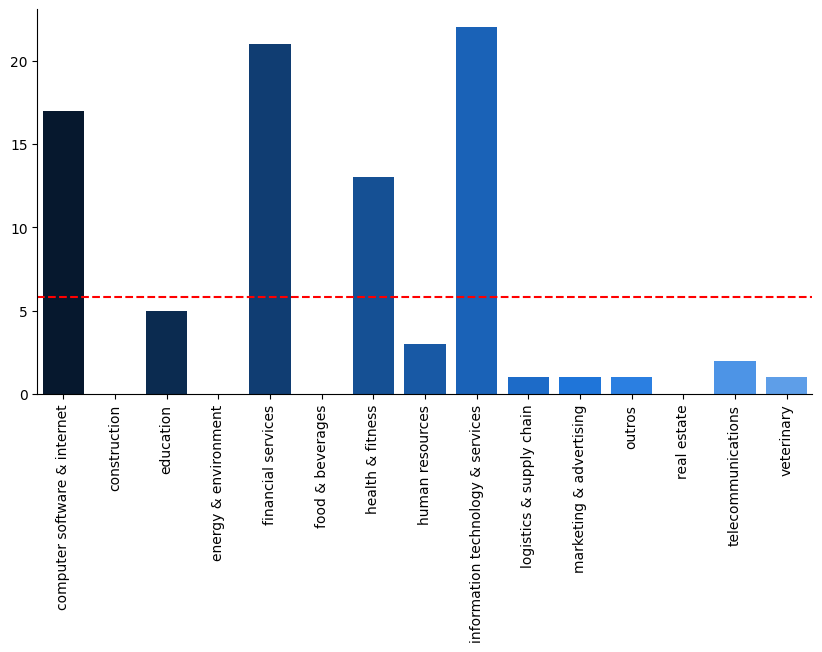

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


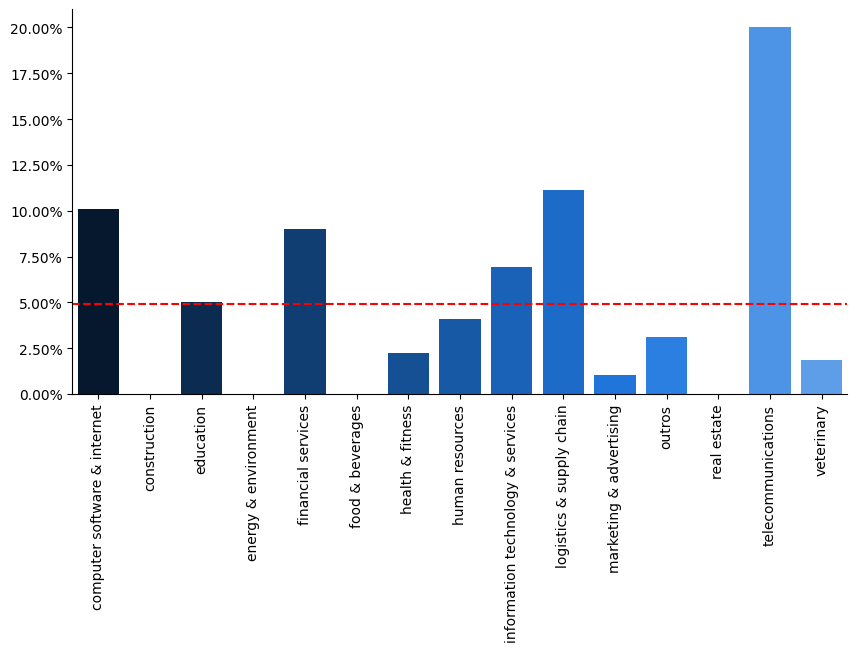

In [15]:
# Create a new column 'employee_category' based on the thresholds


df_companies['employee_category'] = pd.cut(df_companies['Número de Funcionários'], bins=thresholds, labels=labels, right=False)

df_companies.dropna(subset=['employee_category'], inplace=True)

dfmainsectors = df_companies[df_companies['Setor do LinkedIn'].isin(df_companies['Setor do LinkedIn'].value_counts().head(15).index)]

exploratory_report(dfmainsectors, 'STATUS', 'Reunião Marcada', 'Setor do LinkedIn')

In [17]:
# Count the frequency of "Cargo" column

df['Cargo'].value_counts()

Cargo
CEO                                                                                 587
Outros                                                                              477
Founder/Co-founder                                                                  453
Diretor                                                                             325
Sócio                                                                               226
                                                                                   ... 
Owner Principal                                                                       1
Gerente regional                                                                      1
Medical Professor and Coordinator focused on the Expansion of the Art of Healing      1
MANAGER                                                                               1
CDO                                                                                   1
Name: count, Length: 361, 

In [18]:
import pandas as pd
from rapidfuzz import process

# Define the number of most common values to consider
num_common = 10  # Adjust this number as needed
similarity_threshold = 80  # Adjust this threshold as needed

# Get the most common values in 'Cargo'
common_cargos = df['Cargo'].value_counts().index[:num_common]

# Function to apply fuzzy matching with a threshold
def fuzzy_match(cargo, choices, threshold):
    match = process.extractOne(cargo, choices, score_cutoff=threshold)
    if match:
        return match[0]  # match[0] contains the best match string
    else:
        return "others"

# Apply fuzzy matching using the most common values and classify as "others" if no close match
df['Cargo'] = df['Cargo'].apply(lambda x: fuzzy_match(x, common_cargos, similarity_threshold))

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/1619003796.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cargo'] = df['Cargo'].apply(lambda x: fuzzy_match(x, common_cargos, similarity_threshold))


(3835, 2)
Total: 3835
Founder/Co-founder: 477
Sócio: 228
Head: 295
Owner/Co-owner: 119
Diretor: 498
Outros: 533
Gerente: 287
CEO: 629
Diretor Comercial: 102
others: 486
CTO: 181
Founder/Co-founder  Reunião Marcada: 20
Founder/Co-founder  Total%: 477
Percentualmente: 4.19%

Sócio  Reunião Marcada: 10
Sócio  Total%: 228
Percentualmente: 4.39%

Head  Reunião Marcada: 9
Head  Total%: 295
Percentualmente: 3.05%

Owner/Co-owner  Reunião Marcada: 1
Owner/Co-owner  Total%: 119
Percentualmente: 0.84%

Diretor  Reunião Marcada: 9
Diretor  Total%: 498
Percentualmente: 1.81%

Outros  Reunião Marcada: 14
Outros  Total%: 533
Percentualmente: 2.63%

Gerente  Reunião Marcada: 6
Gerente  Total%: 287
Percentualmente: 2.09%

CEO  Reunião Marcada: 16
CEO  Total%: 629
Percentualmente: 2.54%

Diretor Comercial  Reunião Marcada: 1
Diretor Comercial  Total%: 102
Percentualmente: 0.98%

others  Reunião Marcada: 2
others  Total%: 486
Percentualmente: 0.41%

CTO  Reunião Marcada: 1
CTO  Total%: 181
Percentualmen

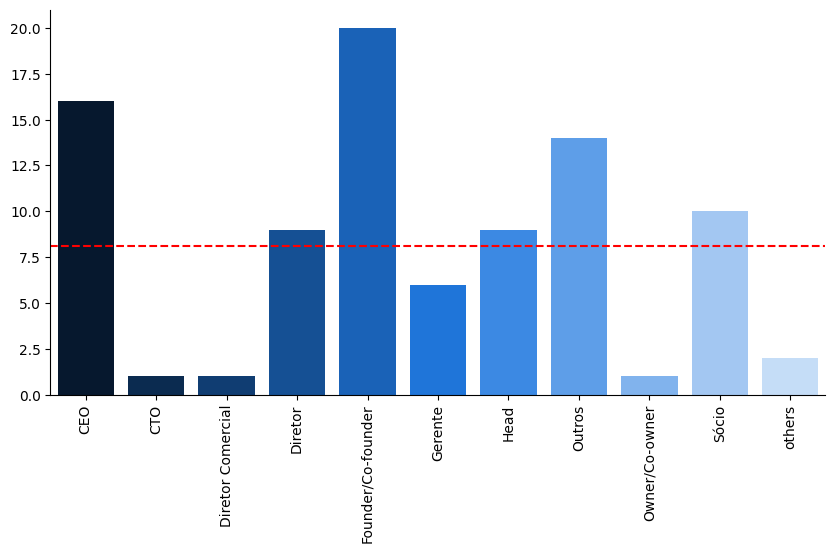

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


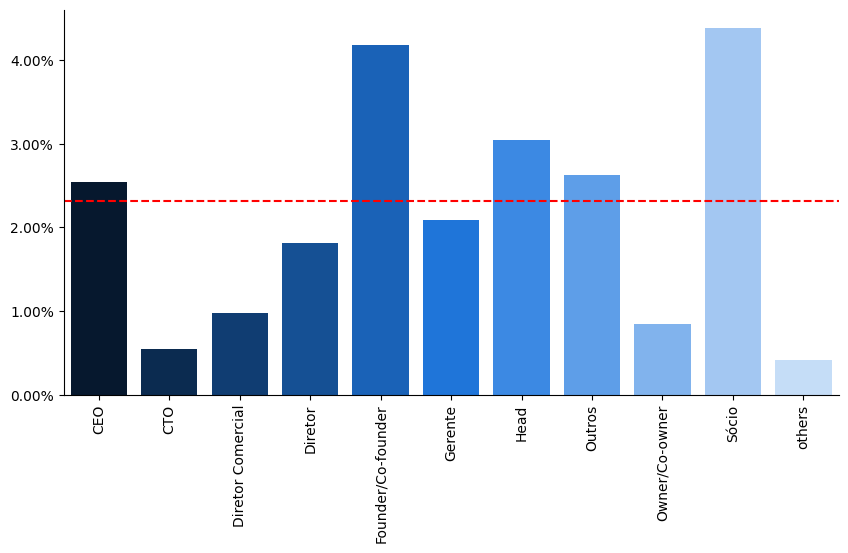

In [19]:
# Create a df with only the most frequent "Cargo" values

dfmaincargo = df[df['Cargo'].isin(df['Cargo'].value_counts().head(15).index)]

exploratory_report(dfmaincargo, 'STATUS', 'Reunião Marcada', 'Cargo')

(3835, 2)
Total: 3835
E-mail: 3077
LinkedIn: 758
E-mail  Reunião Marcada: 57
E-mail  Total%: 3077
Percentualmente: 1.85%

LinkedIn  Reunião Marcada: 32
LinkedIn  Total%: 758
Percentualmente: 4.22%



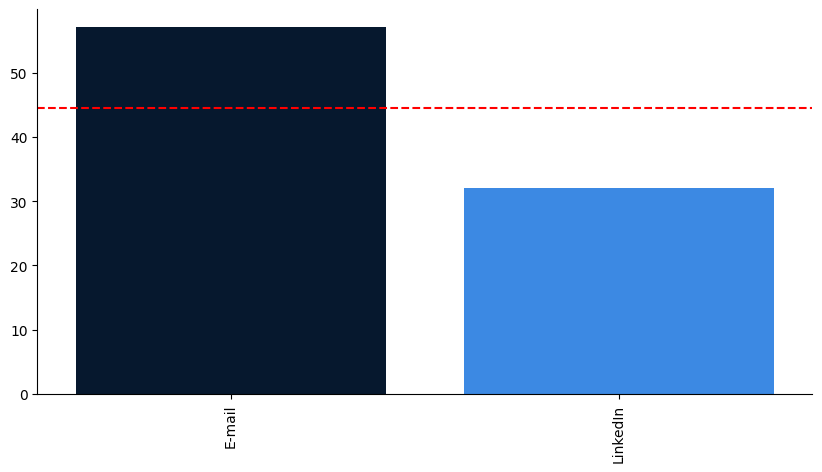

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/815668103.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


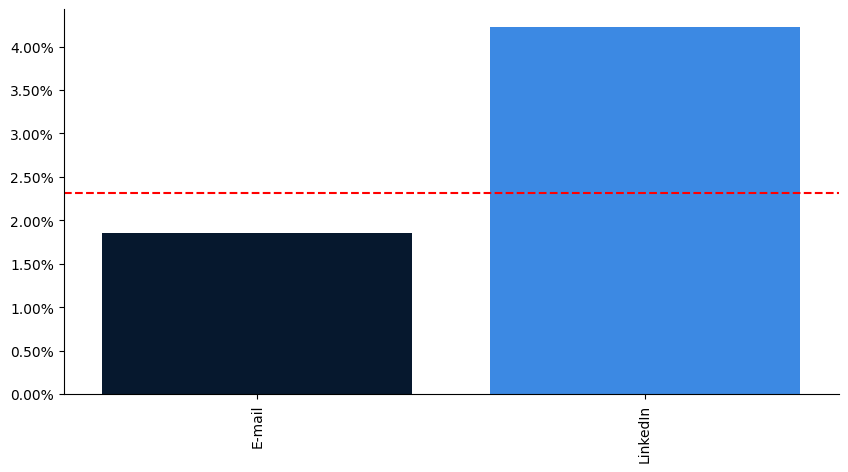

In [21]:
exploratory_report(df, 'STATUS', 'Reunião Marcada', 'Prospecção')

(1846, 2)
Total: 1846
1-50: 1575
51-200: 231
201-500: 21
501-1000: 6
1001-5000: 11
10001+: 1
5001-10000: 1
1-50  Reunião Marcada: 71
1-50  Total%: 1575
Percentualmente: 4.51%

51-200  Reunião Marcada: 14
51-200  Total%: 231
Percentualmente: 6.06%

201-500  Reunião Marcada: 0
201-500  Total%: 21
Percentualmente: 0.00%

501-1000  Reunião Marcada: 2
501-1000  Total%: 6
Percentualmente: 33.33%

1001-5000  Reunião Marcada: 0
1001-5000  Total%: 11
Percentualmente: 0.00%

10001+  Reunião Marcada: 0
10001+  Total%: 1
Percentualmente: 0.00%

5001-10000  Reunião Marcada: 0
5001-10000  Total%: 1
Percentualmente: 0.00%



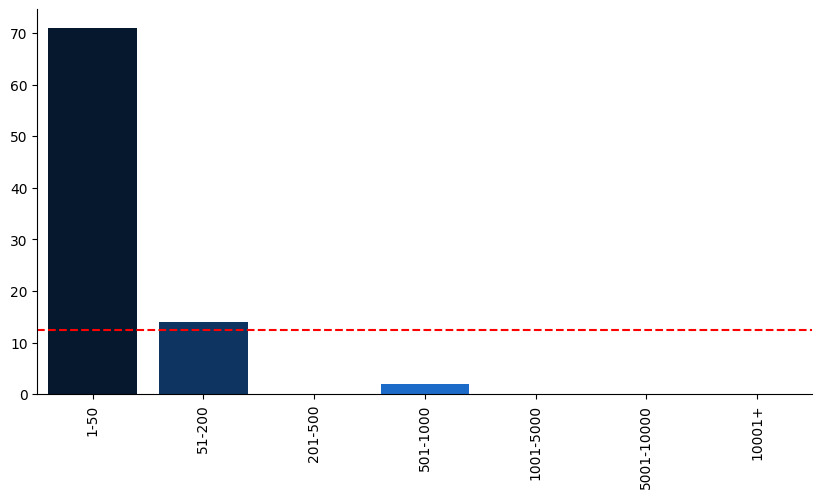

/var/folders/j4/tygk56x10hjb9g65vzjwkljc0000gn/T/ipykernel_5405/815668103.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.2f}%'.format(val) for val in plt.gca().get_yticks()])  # Format y-axis labels with percentage symbol


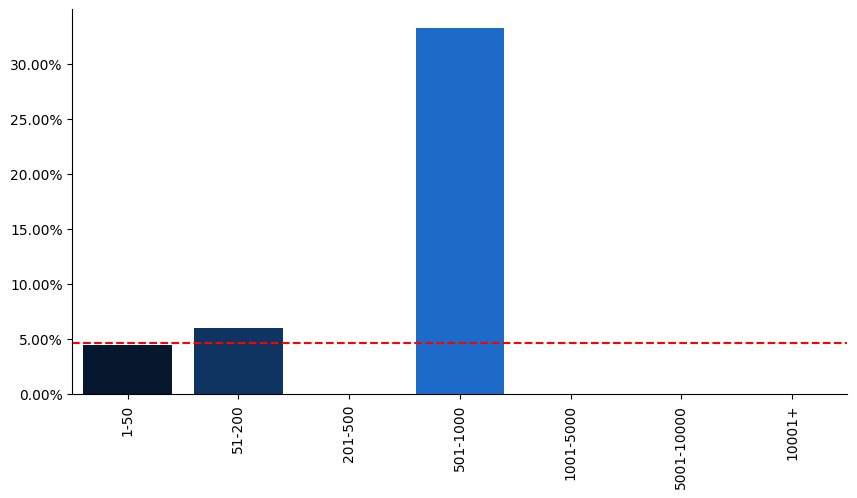

In [23]:
exploratory_report(df_companies, 'STATUS', 'Reunião Marcada', 'employee_category')